# Linear Models assumptions and Polynomial regressions

In order to attemp a different approach, I will start this part of my work by checking on the assumptions of the linear regressions, and see if this gives me a clue on what could be improved.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
diamonds = pd.read_csv('../data/train_cate.csv')
diamonds.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.50,5,7,4,62.3,55.0,5.11,5.07,3.17,1845
1,1,1.54,2,2,5,63.6,60.0,7.30,7.33,4.65,10164
2,2,1.32,3,1,2,61.7,60.0,6.95,7.01,4.31,5513
3,3,1.20,5,2,3,62.1,55.0,6.83,6.79,4.23,5174
4,4,1.73,4,2,3,61.2,60.0,7.67,7.65,4.69,10957


For this approach, I will start by running an Ordinary Least Square on the raw data, so we can recap how our data works together and what metrics it gives to us.

In [4]:
from statsmodels import api

X = api.add_constant(diamonds.iloc[:,1:-1])
y = diamonds.price

ols_model = api.OLS(y, X).fit()

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                 4.416e+04
Date:                Sun, 06 Dec 2020   Prob (F-statistic):               0.00
Time:                        03:18:29   Log-Likelihood:            -3.4485e+05
No. Observations:               40455   AIC:                         6.897e+05
Df Residuals:                   40445   BIC:                         6.898e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2782.8978    546.163      5.095      0.000    1712.406    3853.390
carat       1.085e+04     60.292    179.877      0.000    1.07e+04     1.1e+04
cut          120.8064      6.610     18.276      0.000     107.850     133.763
color        325.2414      3.773     86.198      0.000     317.846     332.637
clarity      503.6992      4.087    123.257      0.000     495.689     511.709
depth        -76.5157      6.688    -11.441      0.000     -89.624     -63.407
table        -28.4147      3.404     -8.347      0.000     -35.087     -21.742
x           -849.1356     51.960    -16.342      0.000    -950.978    -747.293
y             40.2196     21.625      1.860      0.063      -2.166      82.605
z           -127.7329     75.551     -1.691      0.091    -275.815      20.349
==============================================================================
Omnibus:                     9310.342   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           488054.528
Skew:                          -0.143   Prob(JB):                         0.00
Kurtosis:                      20.013   Cond. No.                     7.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Linearity 

In order to verify the assumptions of a Linear Regression for our model, we need to check first for the linearity of our features and the dependent variable. We make this under the assumption that this dependent variable is a linear function of the independent features of the model. 

Let's check this by comparing with a scatter plot the real values against the predictions and the residuals of the model we performed above. We are looking for a plot with data simetrically distributed around a diagonal line in the predictions, and around a horizontal line in the residuals.

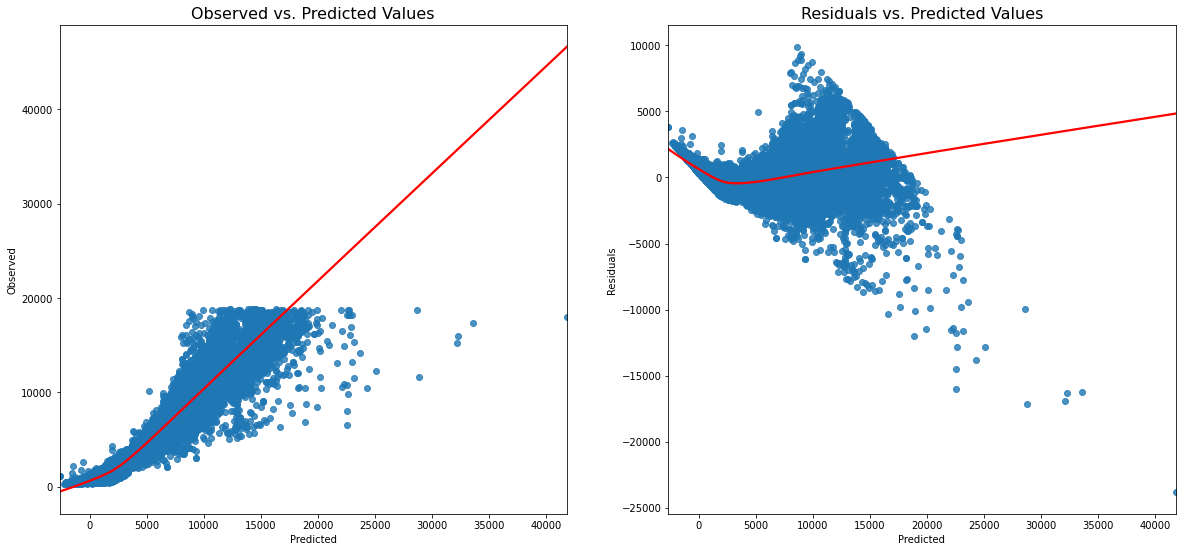

In [28]:
ols_predict = ols_model.predict()
residuals = ols_model.resid

fig, ax = plt.subplots(1,2, figsize=(20,9))
    
sns.regplot(x=ols_predict, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=ols_predict, y=residuals, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
ax[1].set(xlabel='Predicted', ylabel='Residuals');

As the plots show, lines are kind of skewed, and the variances are not following a clear pattern, which means our model makes some errors when predicting, and linearity is not present yet.

### Mean of residuals

Check wheter it is close to zero.

In [16]:
residuals.mean()

1.2523558818056173e-10

### Multicollinearity

That is the independency of the independent features, which can be detected by the variance inflation factor, that shows how much larger the standard error of a variable is compared to what it would be if that variable were uncorrelated with the other variables of the model. The ideal is that all this values are 1.

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns[1:]).T

,carat,cut,color,clarity,depth,table,x,y,z
vif,22.36164,1.489448,1.122685,1.22624,2.504696,1.589044,92.843208,16.951405,75.376491


There are four columns with really high VIF.

### Homoscedasticity of residuals

Now we will check if there is homoscedasticity in our data, which means that its residuals have constant variance, or heteroscedasticity, which could make our following models do unrealistic predictions for out-of-sample data or giving too much weight to some features instead of others when estimating coefficients.

In order to detect heteroscedasticity, we can plot residuals vs fitted values, as I made above. By this plot, it can be appreciated that the distribution of the points is not random, and it follows a pattern where the higher the predicted value is, the smaller the residuals get.

This means that we should reject the hypothesis of homoscedasticity.

### No autocorrelation of residuals

By the Durbin Watson statistic in the OLS test I performed above, we can say, as the value is a bit greatr than 2, that there is a negative autocorrelation among the residuals.

## Create polynomial features

In [4]:
from poly_lasso_cv import poly_lasso_cv, poly_lasso_cv_pred

In [5]:
X = diamonds.iloc[:,1:-1]
y = diamonds.price

In [ ]:
mae_dict, rmse_dict, rsquare_dict = poly_lasso_cv(2, 7, X, y, .2)

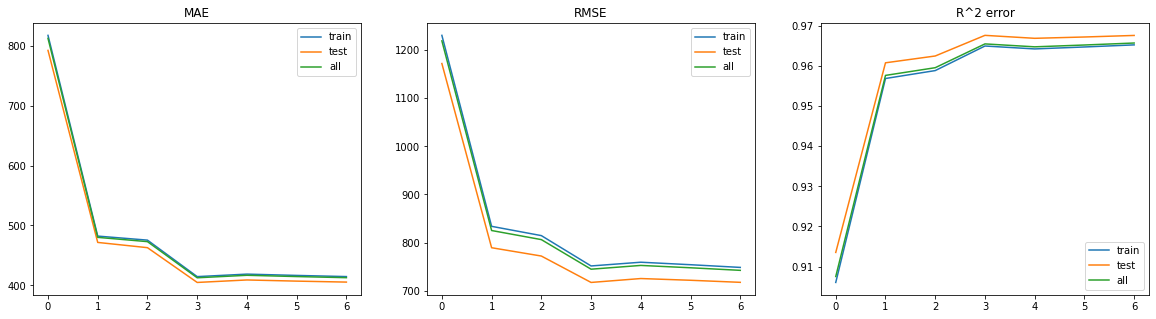

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

pd.DataFrame(mae_dict).plot(ax=axs[0], title='MAE')
pd.DataFrame(rmse_dict).plot(ax=axs[1], title='RMSE')
pd.DataFrame(rsquare_dict).plot(ax=axs[2], title='R^2');

As the plots show, the root mean square error of our model gets to its lower point when the polynomial degree is set to 4 or 7, which is also the highest $R^2$ value and the logest mean average error. 

### Submission

Let's work a prediction for the predictions dataset with a Polynomial model with Lasso Cross Validation.

In [6]:
X_to_pred = pd.read_csv('../data/pred_cate.csv').iloc[:,1:]
X_to_pred.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.45,5,6,3,62.8,58.0,4.88,4.84,3.05
1,1.23,5,3,3,61.0,56.0,6.96,6.92,4.23
2,0.33,5,2,8,61.8,55.0,4.46,4.47,2.76
3,0.51,5,7,4,58.0,60.0,5.29,5.26,3.06
4,0.40,5,6,4,62.2,59.0,4.71,4.74,2.94


In [14]:
prediction = poly_lasso_cv_pred(X, y, 10, X_to_pred)
len(prediction)

13485

In [13]:
diamonds_pred = pd.read_csv('../data/pred_cate.csv')
diamonds_pred['price'] = prediction
diamonds_pred

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.45,5,6,3,62.8,58.0,4.88,4.84,3.05,1197.752466
1,1,1.23,5,3,3,61.0,56.0,6.96,6.92,4.23,6374.170577
2,2,0.33,5,2,8,61.8,55.0,4.46,4.47,2.76,694.388978
3,3,0.51,5,7,4,58.0,60.0,5.29,5.26,3.06,1926.556240
4,4,0.40,5,6,4,62.2,59.0,4.71,4.74,2.94,1081.329314
...,...,...,...,...,...,...,...,...,...,...,...
13480,13480,0.30,5,2,3,62.2,57.0,4.25,4.27,2.65,347.944161
13481,13481,1.01,5,1,4,62.3,55.0,6.40,6.44,4.00,4044.535947
13482,13482,0.33,5,5,7,61.9,55.0,4.43,4.46,2.75,907.107210
13483,13483,0.30,5,4,4,59.3,59.0,4.42,4.38,2.61,486.174292


In [23]:
submission_poly = diamonds_pred.iloc[:,[0,-1]]
submission_poly.set_index('id')

In [28]:
submission_poly.head()

,price
id,
0,1197.752466
1,6374.170577
2,694.388978
3,1926.556240
4,1081.329314
...,...
13480,347.944161
13481,4044.535947
13482,907.107210


In [29]:
submission_poly.to_csv('submissions/poly_lasso_sub1.csv')